SRCNN(Super Resolution CNN)
```
input : low img --> Y
로직 : cnn을 주로 이용, Y는 일반적으로 X를 다운샘플링하고 노이즈가 섞인 형태
output : high img --> X
```
구조
```
3개의 합성곱층
1. Patch Extaction and Representation
  입력 이미지에서 작은 패치를 추출해서 이 패치의 특징을 표현
2. Non-Linear Mapping
  추출한 패치 특징을 더 복잡한 고해상도 패치 공간으로 매핑
3. Resolution
  매핑된 고차원 특징을 다시 고해상도 이미지공간으로 변환  
```
학습과정
```
손실함수 : 평균제곱오차
SRCNN : end to end 방식  저해상도 입력에서 바로 고해상도 출력을 생성
```


In [1]:
# 공유링크를 통해 다운로드
!pip install gdown


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip


In [2]:
# : https://drive.google.com/file/d/17c7kMwVpIm6PqPE3GqJ2Pp7C07Cbg_TL/view?usp=sharing
# 직접다운로드
import gdown
file_id = '17c7kMwVpIm6PqPE3GqJ2Pp7C07Cbg_TL'
gdown.download(f'http://drive.google.com/uc?id={file_id}',quiet=False)

FileURLRetrievalError: Failed to retrieve file url:

	Too many users have viewed or downloaded this file recently. Please
	try accessing the file again later. If the file you are trying to
	access is particularly large or is shared with many people, it may
	take up to 24 hours to be able to view or download the file. If you
	still can't access a file after 24 hours, contact your domain
	administrator.

You may still be able to access the file from the browser:

	http://drive.google.com/uc?id=17c7kMwVpIm6PqPE3GqJ2Pp7C07Cbg_TL

but Gdown can't. Please check connections and permissions.

In [5]:
# 압축 해제
import zipfile
import os
zip_path = './SRCNN_SS.zip'
extract_path = './SRCNN'
with zipfile.ZipFile(zip_path, 'r') as z:
    z.extractall(extract_path)

In [10]:
!pip install --upgrade pip

In [11]:
pip install --upgrade --force-reinstall numpy pandas opencv-python-headless torch torchvision torchaudio albumentations tqdm

  Using cached numpy-2.2.6-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
  Using cached pandas-2.2.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (89 kB)
  Using cached opencv_python_headless-4.11.0.86-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
  Using cached torch-2.7.0-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (29 kB)
  Using cached torchvision-0.22.0-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (6.1 kB)
  Using cached torchaudio-2.7.0-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (6.6 kB)
  Using cached albumentations-2.0.8-py3-none-any.whl.metadata (43 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached python_dateutil-2.9.0.post0-py2.py3-none-any.whl.metadata (8.4 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached filelock-3.18.0-py3-none-any.whl.metadata (2.9 kB)

In [3]:
!pip install -r requirements.txt

  Using cached albucore-0.0.24-py3-none-any.whl.metadata (5.3 kB)
  Using cached albumentations-2.0.8-py3-none-any.whl.metadata (43 kB)
  Using cached annotated_types-0.7.0-py3-none-any.whl.metadata (15 kB)
  Using cached filelock-3.18.0-py3-none-any.whl.metadata (2.9 kB)
  Using cached fsspec-2025.5.1-py3-none-any.whl.metadata (11 kB)
  Using cached gdown-5.2.0-py3-none-any.whl.metadata (5.8 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached MarkupSafe-3.0.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.0 kB)
  Using cached numpy-2.2.6-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
  Using cached nvidia_cublas_cu12-12.6.4.1-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.6.80-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.6.77-py3-none-manylinux2014_x86_64.whl.metadata

In [4]:
!python --version

Python 3.11.11


In [6]:
import random
import pandas as pd
import numpy as np
import os
import cv2
import math
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset ,DataLoader
from tqdm.auto import tqdm
import albumentations as A  # 데이터 증강 라이브러리
from albumentations.pytorch.transforms import ToTensorV2  # 이미지 데이터를 tensor
# 사전 학습 모델  ResNet EfficientNet등..
import torchvision.models as models
from torchvision import transforms

In [7]:
import warnings
warnings.filterwarnings(action='ignore')

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [9]:
IMG_SIZE = 2048
EPOCHS=30
LEARING_RATE=1e-4  #0.0001
BATCH_SIZE=6
SEED = 42

In [38]:
# 데이터 로드
train_df = pd.read_csv('./SRCNN/SRCNN/train.csv')
test_df = pd.read_csv('./SRCNN/SRCNN/test.csv')

In [11]:
from glob import glob
filenames = [files.split('/')[-1] for files in glob('./SRCNN/SRCNN/train/hr/*.*',recursive=True)]
filenames = sorted(filenames)
filenames[0], filenames[-1]

('0000.png', '0010.png')

In [39]:
# 실제 이미지데이터가 10번까지 존재
train_df = train_df.iloc[:11]

In [40]:
'./SRCNN/SRCNN'+train_df['LR'][0][1:]

'./SRCNN/SRCNN/train/lr/0000.png'

In [41]:
# csv의 파일경로와 실제 경로를 매칭
import os
train_df['LR'] = train_df['LR'].apply(lambda x: './SRCNN/SRCNN' + x[1:])
train_df['HR'] = train_df['HR'].apply(lambda x: './SRCNN/SRCNN' + x[1:])

In [42]:
test_df['LR'] = test_df['LR'].apply(lambda x: './SRCNN/SRCNN' + x[1:])

In [43]:
test_df

,LR
0,./SRCNN/SRCNN/test/lr/20000.png
1,./SRCNN/SRCNN/test/lr/20001.png
2,./SRCNN/SRCNN/test/lr/20002.png
3,./SRCNN/SRCNN/test/lr/20003.png
4,./SRCNN/SRCNN/test/lr/20004.png
5,./SRCNN/SRCNN/test/lr/20005.png
6,./SRCNN/SRCNN/test/lr/20006.png
7,./SRCNN/SRCNN/test/lr/20007.png
8,./SRCNN/SRCNN/test/lr/20008.png
9,./SRCNN/SRCNN/test/lr/20009.png


In [44]:
# 데이터셋
# 타입힌트 적용
class SRDataset(Dataset):
  def __init__(self,df:pd.DataFrame,transforms=None,train_mode:bool=True):
    self.df = df
    self.transforms = transforms
    self.train_mode = train_mode

  def __len__(self):
    return len(self.df)

  def __getitem__(self,idx):
    lr_path = self.df['LR'].iloc[idx]
    lr_img = cv2.imread(lr_path)
    # 이미지를 크기변경할때 보간법을 사용
    # INTER_CUBIC : 3차(큐빅)보간법 주변 16개의 픽셀 값을 이용해서 부드럽고 자연스러운 확대 이미지를 생성
    # MASTER : 가장가까운 이웃, LINEAR(선형보간)
    try:
      lr_img = cv2.resize(lr_img, (IMG_SIZE,IMG_SIZE),interpolation=cv2.INTER_CUBIC)
    except Exception as e:
      print(e)
      print(lr_path)
    if self.train_mode:
      hr_path = self.df['HR'].iloc[idx]
      hr_img = cv2.imread(hr_path)
      if self.transforms:
        transformed = self.transforms(image=lr_img,label=hr_img)
        lr_img = transformed['image'] / 255.
        hr_img = transformed['label'] / 255.
        return lr_img, hr_img
    else:
      file_name = lr_path.split('/')[-1]
      if self.transforms:
        transformed = self.transforms(image=lr_img)
        lr_img = transformed['image'] / 255.
      return lr_img, file_name

In [45]:
# 데이터 증강 함수  파이프라인에 사용
def get_train_transforms():
  return A.Compose([
      ToTensorV2(p=1.0)],
      additional_targets={'image':'image','label':'image'}
  )
  def get_test_transforms():
    return A.Compose([
      ToTensorV2(p=1.0)],
      additional_targets={'image':'image','label':'image'}
  )

In [46]:
train_dataset = SRDataset(train_df,get_train_transforms(),True)
train_loader = DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True)

test_dataset = SRDataset(test_df,get_train_transforms(),False)
test_loader = DataLoader(test_dataset,batch_size=BATCH_SIZE,shuffle=False)

In [47]:
next(iter(test_dataset))

(tensor([[[0.6980, 0.6980, 0.6980,  ..., 0.0980, 0.0941, 0.0941],
          [0.6980, 0.6980, 0.6980,  ..., 0.1098, 0.1098, 0.1098],
          [0.6980, 0.6980, 0.6980,  ..., 0.1804, 0.1843, 0.1843],
          ...,
          [0.1098, 0.1098, 0.1098,  ..., 0.2627, 0.2627, 0.2667],
          [0.1098, 0.1098, 0.1098,  ..., 0.2627, 0.2627, 0.2627],
          [0.1098, 0.1098, 0.1098,  ..., 0.2588, 0.2627, 0.2627]],
 
         [[0.8196, 0.8196, 0.8196,  ..., 0.0078, 0.0078, 0.0078],
          [0.8196, 0.8196, 0.8196,  ..., 0.0235, 0.0235, 0.0235],
          [0.8196, 0.8196, 0.8196,  ..., 0.0941, 0.0980, 0.0980],
          ...,
          [0.1216, 0.1216, 0.1216,  ..., 0.1765, 0.1765, 0.1765],
          [0.1216, 0.1216, 0.1216,  ..., 0.1765, 0.1765, 0.1765],
          [0.1216, 0.1216, 0.1216,  ..., 0.1765, 0.1765, 0.1765]],
 
         [[0.9176, 0.9176, 0.9176,  ..., 0.0000, 0.0000, 0.0000],
          [0.9176, 0.9176, 0.9176,  ..., 0.0000, 0.0000, 0.0000],
          [0.9176, 0.9176, 0.9176,  ...,

In [19]:
# ex 입력 3,H,W
class SRCNN(nn.Module):
  def __init__(self,num_channels=3,feature_dim = 64,map_dim=32):
    '''
    feature_dim   첫번째 레이어의 출력수
    map_dim       두번째 레이어의 출력수
    '''
    super(SRCNN,self).__init__()
    # 특징추출
    # 스트라이드 1이고 패딩이 kernel_size // 2 형태면 해상도 유지
    self.features = nn.Sequential(
        nn.Conv2d(num_channels,feature_dim,kernel_size=9,stride=1,padding=4),
        nn.ReLU(inplace=True),
    )
    #특징맵을 더 압축해서 중요한 정보만 남김
    self.map = nn.Sequential(
        nn.Conv2d(feature_dim,map_dim,kernel_size=5,stride=1,padding=2),
        nn.ReLU(inplace=True),
    )
    # 고해상도 이미지 복원
    self.reconstruction = nn.Conv2d(map_dim,num_channels,kernel_size=5,stride=1,padding=2)
  def forward(self,x):
    x = self.features(x)
    x = self.map(x)
    x = self.reconstruction(x)
    return x
  # SRCNN 논문기반으로 가중치 초기화 함수 제작
  # 적절할 가중치 분포를 갖도록 다양한 기법이 존재
  # 1. 공통 conv레이어 초기화
  # 2. 마지막 레이어는 별도 초기화 : 출력이 이미지복원->작은변화에도 민감하게 반응하기 위해서
  def _initialize_weights(self)->None:
    #1
    for module in self.modules():
      if isinstance(module,nn.Conv2d):
        nn.init.normal_(module.weight.data,
                        0.0,
                        # 각 층의 출력분산이 적절하게 유지할수 있도록
                        math.sqrt(2./(module.out_channels*module.weight.data[0][0].numel())))
        if module.bias is not None:
          nn.init.zeros_(module.bias)
    #2
    nn.init.normal_(self.reconstruction.weight.data,0.0,0.001)
    nn.init.zeros_(self.reconstruction.bias.data)

In [20]:
# gpu 메모리 확보
import torch
torch.cuda.empty_cache()

In [23]:
# 학습함수
def train(model,optimizer,train_loader,scheduler,device):
  model.to(device)
  model.train()
  criterion = nn.MSELoss().to(device)
  best_model = None
  best_loss = 9999
  for epoch in range(1,EPOCHS+1):
    train_loss = []
    for lr_img, hr_img in tqdm(iter(train_loader)):
      lr_img, hr_img = lr_img.float().to(device), hr_img.float().to(device)
      optimizer.zero_grad()
      #예측
      pred_hr_img = model(lr_img)
      loss = criterion(pred_hr_img,hr_img)
      #역전파
      loss.backward()
      optimizer.step()
      train_loss.append(loss.item())
    if scheduler is not None:
      scheduler.step()
    _train_loss = np.mean(train_loss)
    print(f'epoch:{epoch} train_loss:{_train_loss:.5f}')
    # best_loss = 0.01    _train_loss =. 0.005
    if best_loss > _train_loss:
      best_loss = _train_loss
      best_model = model
  return best_model

In [24]:
# 모델객체 생성
model = nn.DataParallel(SRCNN())
model.eval()
optimizer = torch.optim.Adam(params=model.parameters(),lr=LEARING_RATE)
# 5에포크마다 학습률을 0.5씩 감소
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=5,gamma=0.5)
trained_model = train(model,optimizer,train_loader,scheduler,device)

  0%|          | 0/2 [00:00<?, ?it/s]

epoch:1 train_loss:0.27254


  0%|          | 0/2 [00:00<?, ?it/s]

epoch:2 train_loss:0.24839


  0%|          | 0/2 [00:00<?, ?it/s]

epoch:3 train_loss:0.22137


  0%|          | 0/2 [00:00<?, ?it/s]

epoch:4 train_loss:0.19941


  0%|          | 0/2 [00:00<?, ?it/s]

epoch:5 train_loss:0.17799


  0%|          | 0/2 [00:00<?, ?it/s]

epoch:6 train_loss:0.15279


  0%|          | 0/2 [00:00<?, ?it/s]

epoch:7 train_loss:0.13697


  0%|          | 0/2 [00:00<?, ?it/s]

epoch:8 train_loss:0.11981


  0%|          | 0/2 [00:00<?, ?it/s]

epoch:9 train_loss:0.10317


  0%|          | 0/2 [00:00<?, ?it/s]

epoch:10 train_loss:0.08687


  0%|          | 0/2 [00:00<?, ?it/s]

epoch:11 train_loss:0.07294


  0%|          | 0/2 [00:00<?, ?it/s]

epoch:12 train_loss:0.06549


  0%|          | 0/2 [00:00<?, ?it/s]

epoch:13 train_loss:0.05956


  0%|          | 0/2 [00:00<?, ?it/s]

epoch:14 train_loss:0.05478


  0%|          | 0/2 [00:00<?, ?it/s]

epoch:15 train_loss:0.04931


  0%|          | 0/2 [00:00<?, ?it/s]

epoch:16 train_loss:0.04483


  0%|          | 0/2 [00:00<?, ?it/s]

epoch:17 train_loss:0.04354


  0%|          | 0/2 [00:00<?, ?it/s]

epoch:18 train_loss:0.04205


  0%|          | 0/2 [00:00<?, ?it/s]

epoch:19 train_loss:0.04060


  0%|          | 0/2 [00:00<?, ?it/s]

epoch:20 train_loss:0.03896


  0%|          | 0/2 [00:00<?, ?it/s]

epoch:21 train_loss:0.03746


  0%|          | 0/2 [00:00<?, ?it/s]

epoch:22 train_loss:0.03565


  0%|          | 0/2 [00:00<?, ?it/s]

epoch:23 train_loss:0.03588


  0%|          | 0/2 [00:00<?, ?it/s]

epoch:24 train_loss:0.03468


  0%|          | 0/2 [00:00<?, ?it/s]

epoch:25 train_loss:0.03464


  0%|          | 0/2 [00:00<?, ?it/s]

epoch:26 train_loss:0.03428


  0%|          | 0/2 [00:00<?, ?it/s]

epoch:27 train_loss:0.03342


  0%|          | 0/2 [00:00<?, ?it/s]

epoch:28 train_loss:0.03286


  0%|          | 0/2 [00:00<?, ?it/s]

epoch:29 train_loss:0.03243


  0%|          | 0/2 [00:00<?, ?it/s]

epoch:30 train_loss:0.03249


In [34]:
# 추론함수
def inference(model,test_loader,device):
    model.to(device)
    # 평가모드로 전환(Dropout, BatchNorm 비활성화)
    pred_img_list = []
    name_list = []
    with torch.no_grad(): # 추론시 Gradient 계산 안함
        for lr_img, file_name in tqdm(iter(test_loader)):
            lr_img =  lr_img.float().to(device)
            # 모델을 통해 예측
            pred_hr_img = model(lr_img)
            for pred,name in zip(pred_hr_img,file_name):
                pred = pred.cpu().clone().detach().numpy()
                pred = pred.transpose(1,2,0) # c h w -> h w c
                pred = pred * 255.  # 정규화 해제 0~1  0 ~ 255
                pred_img_list.append(pred.astype('uint8')) # 이미지 리스트추가
                name_list.append(name) # 파일 이름 저장
    return pred_img_list, name_list


In [48]:
pred_img_list, name_list =  inference(trained_model,test_loader,device)

  0%|          | 0/3 [00:00<?, ?it/s]

In [53]:
!pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 365.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 397.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 52.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5/5 [matplotlib]5 [matplotlib]


In [54]:
# 결과 비교
import matplotlib.pyplot as plt

In [59]:
origin_path = test_df['LR'][0]

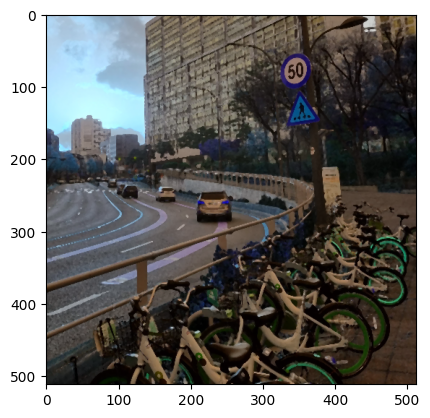

In [64]:
import cv2
plt.imshow( cv2.imread(origin_path))

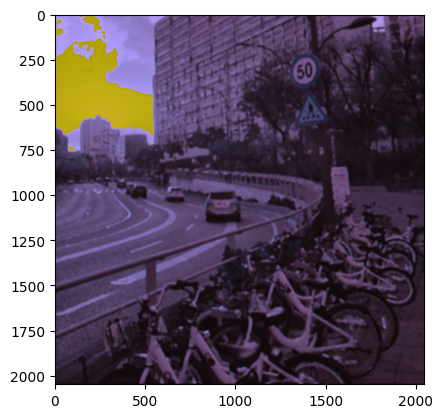

In [66]:
plt.imshow(pred_img_list[0])